# 1. Filtrage de Kalman

## 1.1 Système linéaire gaussien en tems discret

### 1.1.1 Définition

$$
   X_{k+1} = A\,X_{k} + B\,W_k\,,\ 0\leq k < k_{max}
$$

- $X_k\to\mathbb{R}^n$
- bruit: $W_k\to\mathbb{R}^m$, $W_k\sim N(0,Q_W)$
- $A\in\mathbb{R}^{n\times n}$, $B\in\mathbb{R}^{m\times n}$

Il s'agit d'un **système gaussien**: $X_{0:k_{max}}$ est un vecteur aléatoire gaussien. (Notation: $Z_{k':k}=(Z_{k'},Z_{k'+1},\dots ,Z_{k})$, $k'\leq k$).

La moyenne $\bar X_k = \mathbb{E}(X_k)$ et la covariance $Q^X_k = \mathrm{Var}(X_k)$ sont donnés par:


\begin{align*}
   \bar X_{k+1} &= A\,\bar X_{k} 
   \\
   Q^X_{k+1} &= A\,Q^X_{k}\,A^*+B\,Q_W\,B^*
\end{align*}

### 1.1.2 Simulation

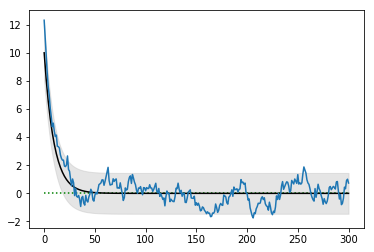

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

kmax = 300

EX0, VX0 = 10, 5
A, B, QW = 0.9, 1, 0.1
sQW = np.sqrt(QW)
sVX0 = np.sqrt(VX0)

def sys_lin(EX0, sVX0, A, B, sQW):
    W = sQW*np.random.randn(kmax)
    X = np.ones(kmax+1)
    X[0] = EX0+sVX0*np.random.randn()
    for k in range(kmax):
        X[k+1] = A*X[k]+B*W[k]
    return X

def sys_lin_loi(EX0, sVX0, A, B, sQW):
    espX = np.ones(kmax+1)
    varX = np.ones(kmax+1)
    espX[0] = EX0
    for k in range(kmax):
        espX[k+1] = A*espX[k]
        varX[k+1] = A*A*varX[k]+B*B*QW
    return espX, varX

X = sys_lin(EX0, sVX0, A, B, sQW)
espX, varX = sys_lin_loi(EX0, sVX0, A, B, sQW)

plt.plot([0, kmax], [0, 0], color="g", linestyle=':')
plt.plot(espX,color='k')
plt.fill_between(range(kmax+1),espX+2*np.sqrt(varX), 
                 espX-2*np.sqrt(varX), color = '0.75', alpha=0.4)
plt.plot(X)
plt.show()

In [3]:
from ipywidgets import interact, fixed

def plt_sys_lin(A, B, iseed):
    np.random.seed(iseed)
    X = sys_lin(10, 0, A, B, 1)
    plt.plot([0, kmax], [0, 0], color="g", linestyle=':')
    plt.plot(X)
    plt.ylim([-4,15])
    plt.show()
    
interact(plt_sys_lin, A=(0,1,0.01), B=(0.,6,0.1), 
         iseed=(1,100,1))
plt.show()


interactive(children=(FloatSlider(value=0.0, description='A', max=1.0, step=0.01), FloatSlider(value=3.0, description='B', max=6.0), IntSlider(value=50, description='iseed', min=1), Output()), _dom_classes=('widget-interact',))

### 1.1.3 Un peu de vectorisation

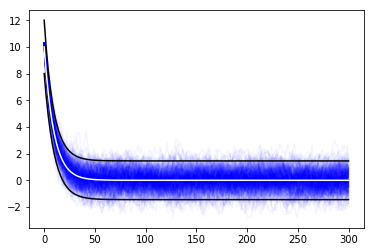

In [4]:
kmax = 300

mcmax = 300
EX0, VX0 = 10, 5
A, B, QW = 0.9, 1, 0.1
sQW = np.sqrt(QW)
sVX0 = np.sqrt(VX0)

def sys_lin_vec(mcmax,EX0, sVX0, A, B, sQW):
    W = sQW*np.random.randn(kmax,mcmax)
    X = np.ones((kmax+1,mcmax))
    X[0,] = EX0+sVX0*np.random.randn()
    for k in range(kmax):
        X[k+1,] = A*X[k,]+B*W[k,]
    return X

X = sys_lin_vec(mcmax, EX0, sVX0, A, B, sQW)
plt.plot(X,alpha=.04,color='b')
plt.plot(espX,color='w')
plt.plot(espX+2*np.sqrt(varX),color='k')
plt.plot(espX-2*np.sqrt(varX),color='k')
plt.show()

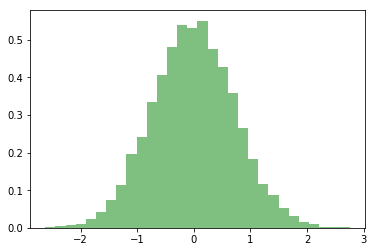

In [5]:
mcmax = 10000
X = sys_lin_vec(mcmax, EX0, sVX0, A, B, sQW)
num_bins = 30
n, bins, patches = plt.hist(X[-1,], num_bins, normed=1, 
                            facecolor='green', alpha=0.5)
plt.show()


## 1.2 Loi conditionnelle gaussienne

Soit $Z=\left(\begin{matrix}X \\ Y\end{matrix}\right)$ un vecteur aléatoire gaussien à valeurs dans $\mathbb R^{n+d}$ de moyenne $\bar Z$ et de covariance $Q_Z$ avec:

\begin{align*}
   \bar Z &= \begin{pmatrix}\bar X \\ \bar Y \end{pmatrix}
   &
   Q_Z &=\begin{pmatrix} Q_{X X} & Q_{XY} \\ Q_{XY}^* &
                         Q_{YY}\end{pmatrix}
\end{align*}

où $Q_{YY}>0$ alors $X|Y$ est gaussien $N(\widehat{X},R)$ avec:

\begin{align*}
  \widehat{X}
  &=
  \bar X + Q_{XY}\,Q_{YY}^{-1}\,(Y-\bar Y)
  &
  R
  &=
  Q_{XX}-Q_{XY}\,Q_{YY}^{-1}\,Q_{XY}^*
\end{align*}

In [6]:
import scipy.stats as stats

barZ = np.array([[1],[3]])
QZ = np.array([[3,1],[1,1]])

a = barZ[0]
b = QZ[0,0]
xx = np.linspace(-6, 10, 100)

R = QZ[0,0]-QZ[0,1]*QZ[0,1]/QZ[1,1]

def pltbayesgauss(obs):
    hatX = barZ[0]+QZ[0,1]*(obs-barZ[1])/QZ[1,1]
    plt.plot([obs,obs],[0,1],':')
    plt.plot(xx, stats.norm.pdf(xx, a, b),label='loi a priori')
    plt.plot(xx, stats.norm.pdf(xx, hatX, R),label='loi a posteriori')
    plt.ylim([0,0.25])
    plt.legend()
    plt.show()

interact(pltbayesgauss, obs=(-6,10,0.1))
plt.show()

interactive(children=(FloatSlider(value=2.0, description='obs', max=10.0, min=-6.0), Output()), _dom_classes=('widget-interact',))

## 1.3 Problème de filtrage linéaire

\begin{align*}
\tag{équation d'état}
   X_{k+1} &= A\,X_{k} + B\,W_k\,\ 0\leq k<k_{max}
   \\
\tag{équation d'observation}
   Y_{k} &= H\,X_{k} + V_k   \,\ 0< k\leq k_{max}
\end{align*}

- $X_k\to\mathbb{R}^n$, $Y_k\to\mathbb{R}^d$
- bruit d'état: $W_k\to\mathbb{R}^m$, $W_k\sim N(0,Q_W)$
- bruit de mesure: $V_k\to\mathbb{R}^d$, $V_k\sim N(0,Q_V)$, $Q_V>0$
- $A\in\mathbb{R}^{n\times n}$, $B\in\mathbb{R}^{m\times n}$, $H\in\mathbb{R}^{n\times d}$

Il s'agit d'un **système gaussien**: $(X_0,\dots,X_{k_{max}},Y_1,\dots,Y_{k_{max}})$ est un vecteur aléatoire gaussien. (Notation: $Z_{k':k}=(Z_{k'},Z_{k'+1},\dots ,Z_{k})$, $k'\leq k$).

**Filtrage:** On veut estimer l'état caché à l'aide des observations. À l'instant $k$, on dispose des observations $Y_{1:k}$ et on veut estimer $X_k$. 


La loi de $X_k$ sachant les observations $Y_{1:k}$ est gaussienne de moyenne $\widehat{X}_k$ et de covariance $R_k$ donné par:
> **initialisation**
>   - $\widehat{X}_0 \leftarrow \bar{X}_0$ 
>   - $R_0 \leftarrow Q_0$ 
>
> **itérations** $k=1,2,3\dots$
>   - **prédiction** (calcul de la loi de $X_k|Y_{0:k-1}$)
>        * $\widehat{X}_{k^-} \leftarrow A\,\widehat{X}_{k-1} $
>        * $R_{k^-} \leftarrow  A\,R_{k-1}\,A^* + B\,Q^W\,B^*$
>   - **correction** (calcul de la loi de $X_k|Y_{0:k}$)
>        * $K_k \leftarrow R_{k^-}\,H^*\;[ H\,R_{k^-}\,H^*+Q^ V ]^{-1}$  gain
>        * $\widehat{X}_k \leftarrow \widehat{X}_{k^-} + K_k\;[ { Y_k}-H\,\widehat{X}_{k^-}]$
>        * $R_k \leftarrow [ I-K_k\,H ]\;R_{k^-}$





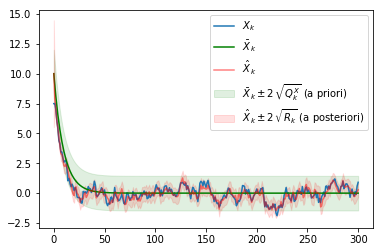

In [7]:
import numpy as np
import matplotlib.pyplot as plt

kmax = 300

EX0, VX0 = 10, 5
A, B, QW = 0.9, 1, 0.1
H, QV = 1, 0.2
sQW = np.sqrt(QW)
sQV = np.sqrt(QV)
sVX0 = np.sqrt(VX0)

def sys_lin_esp_etat(EX0, sVX0, A, B, H, sQW, sQV):
    W = sQW*np.random.randn(kmax)
    V = sQV*np.random.randn(kmax)
    X = np.ones(kmax+1)
    Y = np.ones(kmax+1)
    X[0] = EX0+sVX0*np.random.randn()
    Y[0] = 0 # on s en moque
    for k in range(kmax):
        X[k+1] = A*X[k]+B*W[k]
        Y[k+1] = H*X[k+1]+V[k]
    return X,Y

def kalman(EX0, sVX0, A, B, H, sQW, sQV, Y):
    hatX = np.ones(kmax+1)
    R = np.ones(kmax+1)
    hatX[0] = EX0
    R[0] = sVX0*sVX0
    for k in range(kmax):
        # prediction
        predX = A*hatX[k]
        predR = A*A*R[k]+B*B*sQW*sQW
        # correction
        gain = predR * H / (H*predR*H+sQV*sQV)
        hatX[k+1] = predX + gain * (Y[k+1]-H*predX)
        R[k+1] = (1-gain*H)*predR
    return hatX, R

X,Y = sys_lin_esp_etat(EX0, sVX0, A, B, H, sQW, sQV)
espX, varX = sys_lin_loi(EX0, sVX0, A, B, sQW)
hatX, R = kalman(EX0, sVX0, A, B, H, sQW, sQV, Y)

plt.fill_between(range(kmax+1),espX+2*np.sqrt(varX),
                 espX-2*np.sqrt(varX), 
                 color = 'g', alpha=0.12,
                 label=r'$\bar X_k\pm 2\,\sqrt{Q^X_k}$ (a priori)')
plt.fill_between(range(kmax+1),hatX+2*np.sqrt(R),
                 hatX-2*np.sqrt(R), 
                 color = 'r', alpha=0.12,
                 label=r'$\hat X_k\pm 2\,\sqrt{R_k}$ (a posteriori)')
plt.plot(X,label=r'$X_k$')
plt.plot(espX,color='g',label=r'$\bar X_k$')
plt.plot(hatX,color='r',alpha=0.5,label=r'$\hat X_k$')

plt.legend()
plt.show()

## 1.4 Filtre de Kalman étendu

### 1.4.1 Filtrage non linéaire en temps dicsret

\begin{align*}
\tag{équation d'état}
   X_{k+1} &= f(X_{k}) + \sigma\,W_k\,\ 0\leq k<k_{max}
   \\
\tag{équation d'observation}
   Y_{k} &= h(X_{k}) + V_k   \,\ 0< k\leq k_{max}
\end{align*}

- $X_k\to\mathbb{R}^n$, $Y_k\to\mathbb{R}^d$
- bruit d'état: $W_k\to\mathbb{R}^m$, $W_k\sim N(0,Q_W)$
- bruit de mesure: $V_k\to\mathbb{R}^d$, $V_k\sim N(0,Q_V)$, $Q_V>0$

**Filtrage:** On veut estimer l'état caché à l'aide des observations. À l'instant $k$, on dispose des observations $Y_{1:k}$ et on veut estimer $X_k$. 

En général: pas de solution en dimension finie


### 1.4.2 Filtre de Kalman étendu en temps discret

La loi de $X_k$ sachant les observations $Y_{1:k}$ est gaussienne de moyenne $\widehat{X}_k$ et de covariance $R_k$ donné par:
> **initialisation**
>   - $\widehat{X}_0 \leftarrow \bar{X}_0$ 
>   - $R_0 \leftarrow Q_0$ 
>
> **itérations** $k=1,2,3\dots$
>   - **prédiction** (calcul de la loi de $X_k|Y_{0:k-1}$)
>        * $F_{k-1} \leftarrow \nabla f(\widehat{X}_{k-1})$
>        * $\widehat{X}_{k^-} \leftarrow f(\widehat{X}_{k-1}) $
>        * $R_{k^-} \leftarrow  F_{k-1}\,R_{k-1}\,F_{k-1}^* + \sigma\,Q^W\,\sigma^*$
>   - **correction** (calcul de la loi de $X_k|Y_{0:k}$)
>        * $H_k \leftarrow \nabla h(\widehat{X}_{k^-}) $
>        * $K_k \leftarrow R_{k^-}\,H_k^*\;[ H_k\,R_{k^-}\,H_k^*+Q^ V ]^{-1}$  gain
>        * $\widehat{X}_k \leftarrow \widehat{X}_{k^-} + K_k\;[ { Y_k}-h(\widehat{X}_{k^-})]$
>        * $R_k \leftarrow [ I-K_k\,H_h ]\;R_{k^-}$

## 1.5 Cas linéaire continu/discret

\begin{align*}
\dot X(t) &= f(X(t)) + \sigma\,\xi(t) \tag{équation d'état}  \\
Y_{k} &= H\,X(t_k) + V_k   \tag{équation d'observation}
\end{align*}

- $0=t_1<t_1<t_2\cdots$
- $X(t)\to\mathbb{R}^n$, $Y_k\to\mathbb{R}^d$
- bruit d'état: $\xi(t)$ bruit blanc gaussien centré de covariance $Q_\xi$
- bruit de mesure: $V_k\to\mathbb{R}^d$, $V_k\sim N(0,Q_V)$, $Q_V>0$
- $A\in\mathbb{R}^{n\times n}$, $B\in\mathbb{R}^{m\times n}$, $H\in\mathbb{R}^{n\times d}$

### 1.5.1 Equation d'état

Si $t_k=k\,\delta$ alors:

$$
  X(t_{k+1}) = X(t_k) + \delta \,f(X(t_k)) + \sigma \,W_k
$$

où

$$
  W_k =  \int_{t_k}^{t_{k+1}} \xi_s\,ds
$$

est un bruit blanc gaussien discret de covariance $\delta\,Q_\xi$

### 1.5.2 Filtre de Kalman étendu continu/discret



> **initialisation**
>   - $\widehat{X}(0) \leftarrow \bar{X}_0$ 
>   - $R(0) \leftarrow Q_0$ 
>
> **itérations** $k=1,2,3\dots$
>   - **prédiction**  calcul de la loi de $X(t)|Y_{0:k-1}$ pour $t_{k-1}<t<t_k$:

>\begin{align*}
 (d/dt) \widehat{X}^-(t)  &= f(\widehat{X}^-(t))  \\
 (d/dt) R^-(t)&=  \nabla f(\widehat{X}^-(t))\,R^-(t)+R^-(t)\,\nabla f(\widehat{X}^-(t))^* + \sigma\,Q_\xi\,\sigma^*\\
 &\textrm{avec } \widehat{X}^-(t_{k-1})=\widehat{X}(t_{k-1})\,,\ R^-(t_{k-1})=R(t_{k-1})
\end{align*}

>   - **correction** (calcul de la loi de $X(t_k)|Y_{0:k}$)

>\begin{align*}
  H_k &\leftarrow \nabla h(\widehat{X}^-(t_k)) \\
  K_k &\leftarrow R^-(t_k)\,H_k^*\;[ H_k\,R^-(t_k)\,H_k^*+Q^ V ]^{-1}\\
  \widehat{X}(t_k) &\leftarrow \widehat{X}^-(t_k)  + K_k\;[ Y_k-h(\widehat{X}^-(t_k))] \\
  R(t_k) &\leftarrow [ I-K_k\,H_h ]\;R^-(t_k)
\end{align*}

